# Integration, label transfer and multi-scale analysis with scPoli

In this notebook we demonstrate an example workflow of data integration, reference mapping, label transfer and multi-scale analysis of sample and cell embeddings using scPoli. We integrate pancreas data obtained from the [scArches reproducibility repository](https://github.com/theislab/scArches-reproducibility). The data can be downloaded from [figshare](https://figshare.com/articles/dataset/pancreas_h5ad/21878426).

In [1]:
import os
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from scarches.models.scpoli import scPoli

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

INFO:pytorch_lightning.utilities.seed:Global seed set to 0
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/carlo.dedonno/anaconda3/envs/scarches/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)
 captum (see https://github.com/pytorch/captum).


In [2]:
sc.settings.set_figure_params(dpi=100, frameon=False)
sc.set_figure_params(dpi=100)
sc.set_figure_params(figsize=(3, 3))
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (3, 3)

In [3]:
adata = sc.read('../../../lataq_reproduce/data/pancreas.h5ad')
adata

AnnData object with n_obs × n_vars = 16382 × 4000
    obs: 'study', 'cell_type', 'pred_label', 'pred_score'
    obsm: 'X_seurat', 'X_symphony'

In [4]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


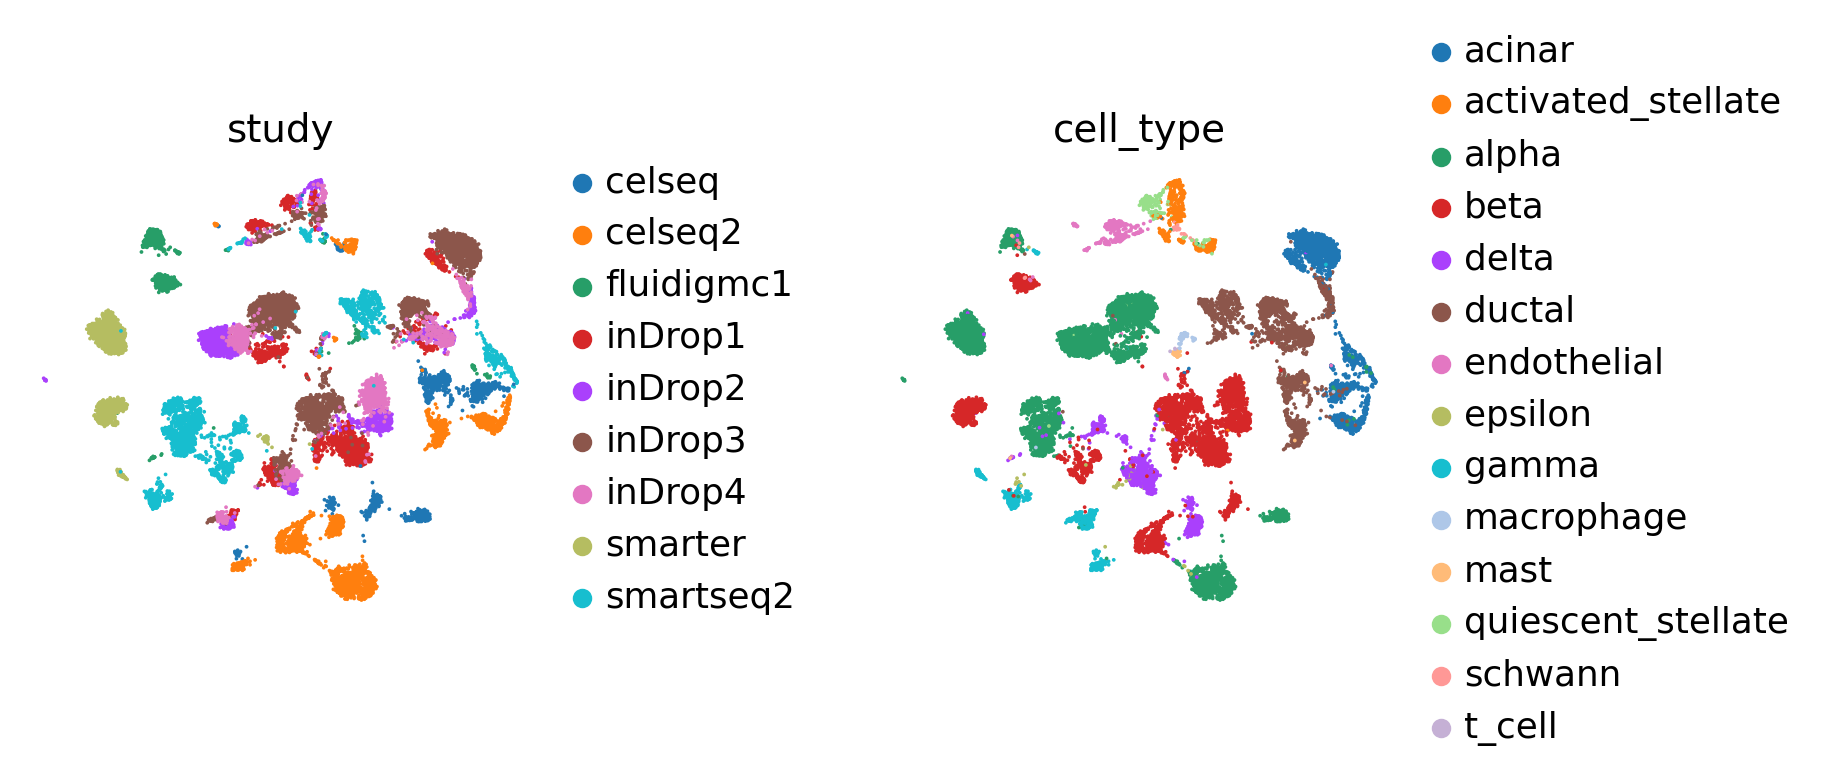

In [5]:
sc.pl.umap(adata, color=['study', 'cell_type'], wspace=0.5, frameon=False)

In [6]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_prototype_loss",
    "mode": "min",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

condition_key = 'study'
cell_type_key = 'cell_type'
reference = [
    'inDrop1', 
    'inDrop2', 
    'inDrop3', 
    'inDrop4', 
    'fluidigmc1', 
    'smartseq2', 
    'smarter'
]
query = ['celseq', 'celseq2']

## Reference - query split
We split our data in a group of reference datasets to be used for reference building, and a group of query datasets that we will map.

In order to simulate an unknown cell type scenario, we manually remove beta cells from the reference.

In [7]:
adata.obs['query'] = adata.obs[condition_key].isin(query)
adata.obs['query'] = adata.obs['query'].astype('category')
source_adata = adata[adata.obs.study.isin(reference)].copy()
source_adata = source_adata[~source_adata.obs.cell_type.str.contains('alpha')].copy()
target_adata = adata[adata.obs.study.isin(query)].copy()

In [8]:
source_adata, target_adata

(AnnData object with n_obs × n_vars = 8634 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities',
 AnnData object with n_obs × n_vars = 3289 × 4000
     obs: 'study', 'cell_type', 'pred_label', 'pred_score', 'query'
     uns: 'neighbors', 'umap', 'study_colors', 'cell_type_colors'
     obsm: 'X_seurat', 'X_symphony', 'X_pca', 'X_umap'
     obsp: 'distances', 'connectivities')

## Train reference scPoli model on fully labeled reference data

Explanation of scPoli parameters:

Model:
- **condition_keys**: obs column names of the covariate(s) you want to use for integration, if a list of names is passed, the model will use independent embeddings for each covariate
- **cell_type_keys**: obs column names of the cell type annotation(s) to use for prototype learning, if a list is passed, the model will compute the prototype loss in parallel for each set of annotations passed
- **embedding_dims**: embedding dimensionality, if an integer is passed, the model will use embeddings of the same dimensionality for each covariate, if the user wishes to define different dimensionalities for each covariate, a list needs to be provided

Training:
- **pretraining_epochs**: number of epochs for which the model is trained in an unsupervised fashion
- **n_epochs**: total number of training epochs, finetuning epochs therefore will be (n_epochs - pretraining_epochs)
- **eta**: weight of the prototype loss
- **prototype_training**: flag that can be used to turn off prototype training
- **unlabeled_prototype_training**: flag that can be used to skip unlabeled prototype computation. This step involves Louvain clustering and can be time-consuming on big datasets. Unlabeled prototypes can be useful for downstream analyses but are not used at training time.

In [9]:
scpoli_model = scPoli(
    adata=source_adata,
    condition_keys=condition_key,
    cell_type_keys=cell_type_key,
    embedding_dims=5,
    recon_loss='nb',
)
scpoli_model.train(
    n_epochs=50,
    pretraining_epochs=40,
    early_stopping_kwargs=early_stopping_kwargs,
    eta=5,
)

Embedding dictionary:
 	Num conditions: [7]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 4000 64 5
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 5
	Output Layer in/out:  64 4000 

Initializing dataloaders
Starting training
 |████████████████████| 100.0%  - val_loss: 1091.81 - val_cvae_loss: 1079.83 - val_prototype_loss:   11.98 - val_labeled_loss:    2.40


We recommend using a **pretraining/training epoch ratio** of approximately 80 or 90%. If you train for more total epochs you should use a higher ratio, whereas if you're training for only a few epochs, this ratio can be smaller. If the model is trained withthe prototype loss for too many epochs it can lead to very concentrated clusters in latent space.

## Reference mapping of unlabeled query datasets

In [10]:
scpoli_query = scPoli.load_query_data(
    adata=target_adata,
    reference_model=scpoli_model,
    labeled_indices=[],
)

Embedding dictionary:
 	Num conditions: [9]
 	Embedding dim: [5]
Encoder Architecture:
	Input Layer in, out and cond: 4000 64 5
	Mean/Var Layer in/out: 64 10
Decoder Architecture:
	First Layer in, out and cond:  10 64 5
	Output Layer in/out:  64 4000 



In [11]:
scpoli_query.train(
    n_epochs=50,
    pretraining_epochs=40,
    eta=10
)

The missing labels are: {'alpha'}
Therefore integer value of those labels is set to -1
The missing labels are: {'alpha'}
Therefore integer value of those labels is set to -1
Initializing dataloaders
Starting training
 |████████████████----| 80.0%  - val_loss: 1766.09 - val_cvae_loss: 1766.09
Initializing unlabeled prototypes with Leiden with an unknown number of  clusters.
Clustering succesful. Found 21 clusters.
 |████████████████████| 100.0%  - val_loss: 1760.48 - val_cvae_loss: 1760.48 - val_prototype_loss:    0.00 - val_unlabeled_loss:    0.57


## Label transfer from reference to query

The uncertainties returned by the model consist of the distance between the cell in the latent space and the labeled prototypes closest to it. This distance does not have an upper bound, and the scale of the distance can provide information on the heterogeneity of the dataset. We also offer the option to scale the uncertainties between 0 and 1. 

In [14]:
results_dict = scpoli_query.classify(target_adata, scale_uncertainties=True)

Let's check the label transfer performance we achieved.

In [18]:
for i in range(len(cell_type_key)):
    preds = results_dict[cell_type_key]["preds"]
    results_dict[cell_type_key]["uncert"]
    classification_df = pd.DataFrame(
        classification_report(
            y_true=target_adata.obs[cell_type_key],
            y_pred=preds,
            output_dict=True,
        )
    ).transpose()
print(classification_df)

                    precision    recall  f1-score      support
acinar               0.964497  0.974104  0.969277   502.000000
activated_stellate   0.900826  1.000000  0.947826   109.000000
alpha                0.000000  0.000000  0.000000  1034.000000
beta                 0.966019  0.985149  0.975490   606.000000
delta                0.547253  0.984190  0.703390   253.000000
ductal               0.969178  0.967521  0.968349   585.000000
endothelial          1.000000  1.000000  1.000000    26.000000
epsilon              0.067568  1.000000  0.126582     5.000000
gamma                0.147465  1.000000  0.257028   128.000000
macrophage           1.000000  0.937500  0.967742    16.000000
mast                 1.000000  0.714286  0.833333     7.000000
quiescent_stellate   1.000000  0.615385  0.761905    13.000000
schwann              1.000000  1.000000  1.000000     5.000000
t_cell               0.000000  0.000000  0.000000     0.000000
accuracy             0.669504  0.669504  0.669504     0

In [19]:
#get latent representation of reference data
scpoli_query.model.eval()
data_latent_source = scpoli_query.get_latent(
    source_adata, 
    mean=True
)

adata_latent_source = sc.AnnData(data_latent_source)
adata_latent_source.obs = source_adata.obs.copy()

#get latent representation of query data
data_latent= scpoli_query.get_latent(
    target_adata, 
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = target_adata.obs.copy()

#get label annotations
adata_latent.obs['cell_type_pred'] = results_dict['cell_type']['preds'].tolist()
adata_latent.obs['cell_type_uncert'] = results_dict['cell_type']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['cell_type_pred'] == adata_latent.obs['cell_type']
)

#get prototypes
labeled_prototypes = scpoli_query.get_prototypes_info()
labeled_prototypes.obs['study'] = 'labeled prototype'
unlabeled_prototypes = scpoli_query.get_prototypes_info(prototype_set='unlabeled')
unlabeled_prototypes.obs['study'] = 'unlabeled prototype'

#join adatas
adata_latent_full = adata_latent_source.concatenate(
    [adata_latent, labeled_prototypes, unlabeled_prototypes], 
    batch_key='query'
)
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = np.nan
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

In [20]:
#get adata without prototypes
adata_no_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['0', '1'])]

<AxesSubplot: title={'center': 'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

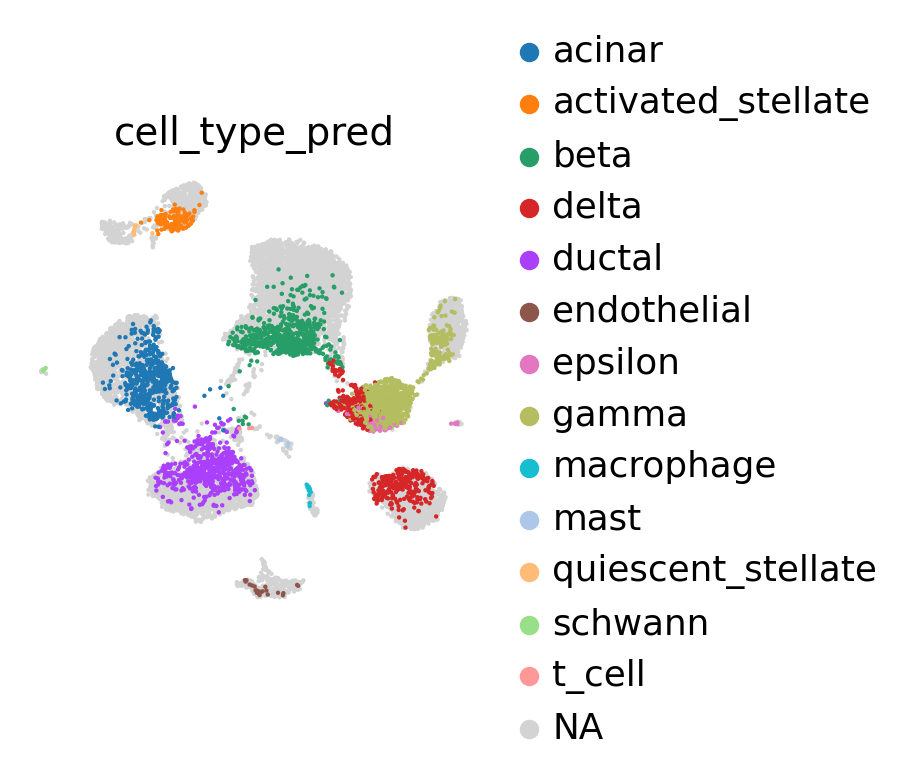

In [21]:
sc.pl.umap(
    adata_no_prototypes, 
    color='cell_type_pred',
    show=False, 
    frameon=False,
)

<AxesSubplot: title={'center': 'study'}, xlabel='UMAP1', ylabel='UMAP2'>

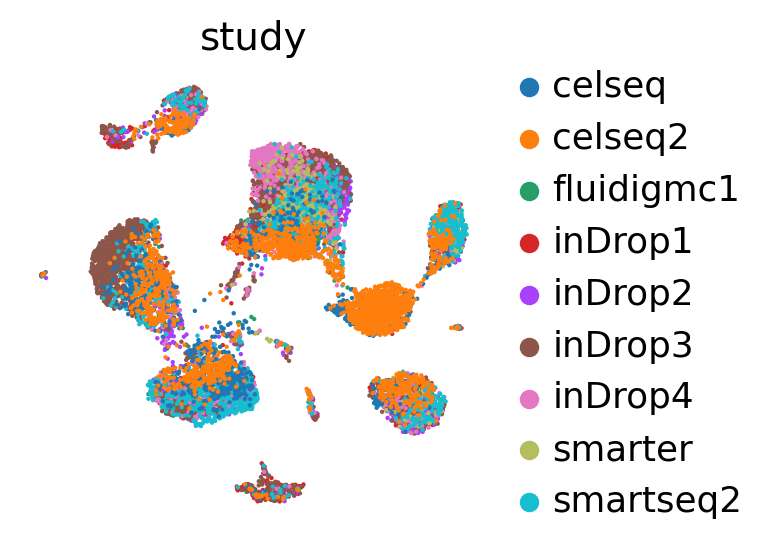

In [22]:
sc.pl.umap(
    adata_no_prototypes, 
    color='study',
    show=False, 
    frameon=False,
)

## Inspect uncertainty
We can look at the uncertainty of each prediction and either select a threshold after visual inspection or by looking at the percentiles of the uncertainties distribution.

<AxesSubplot: title={'center': 'cell_type_uncert'}, xlabel='UMAP1', ylabel='UMAP2'>

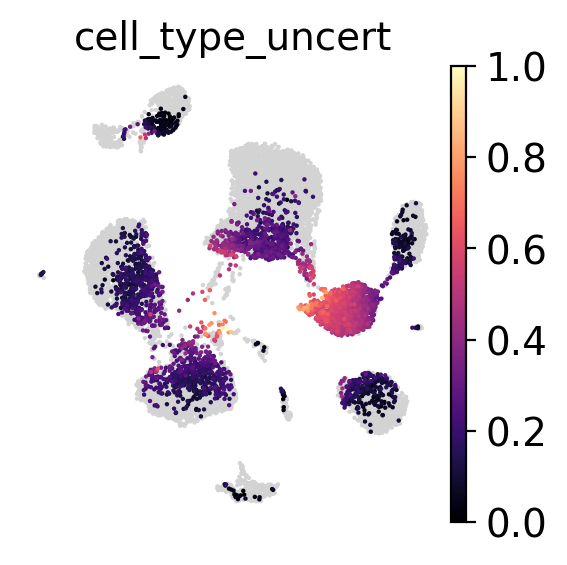

In [23]:
sc.pl.umap(
    adata_no_prototypes, 
    color='cell_type_uncert',
    show=False, 
    frameon=False,
    cmap='magma',
    vmax=1
)

## Inspect prototypes

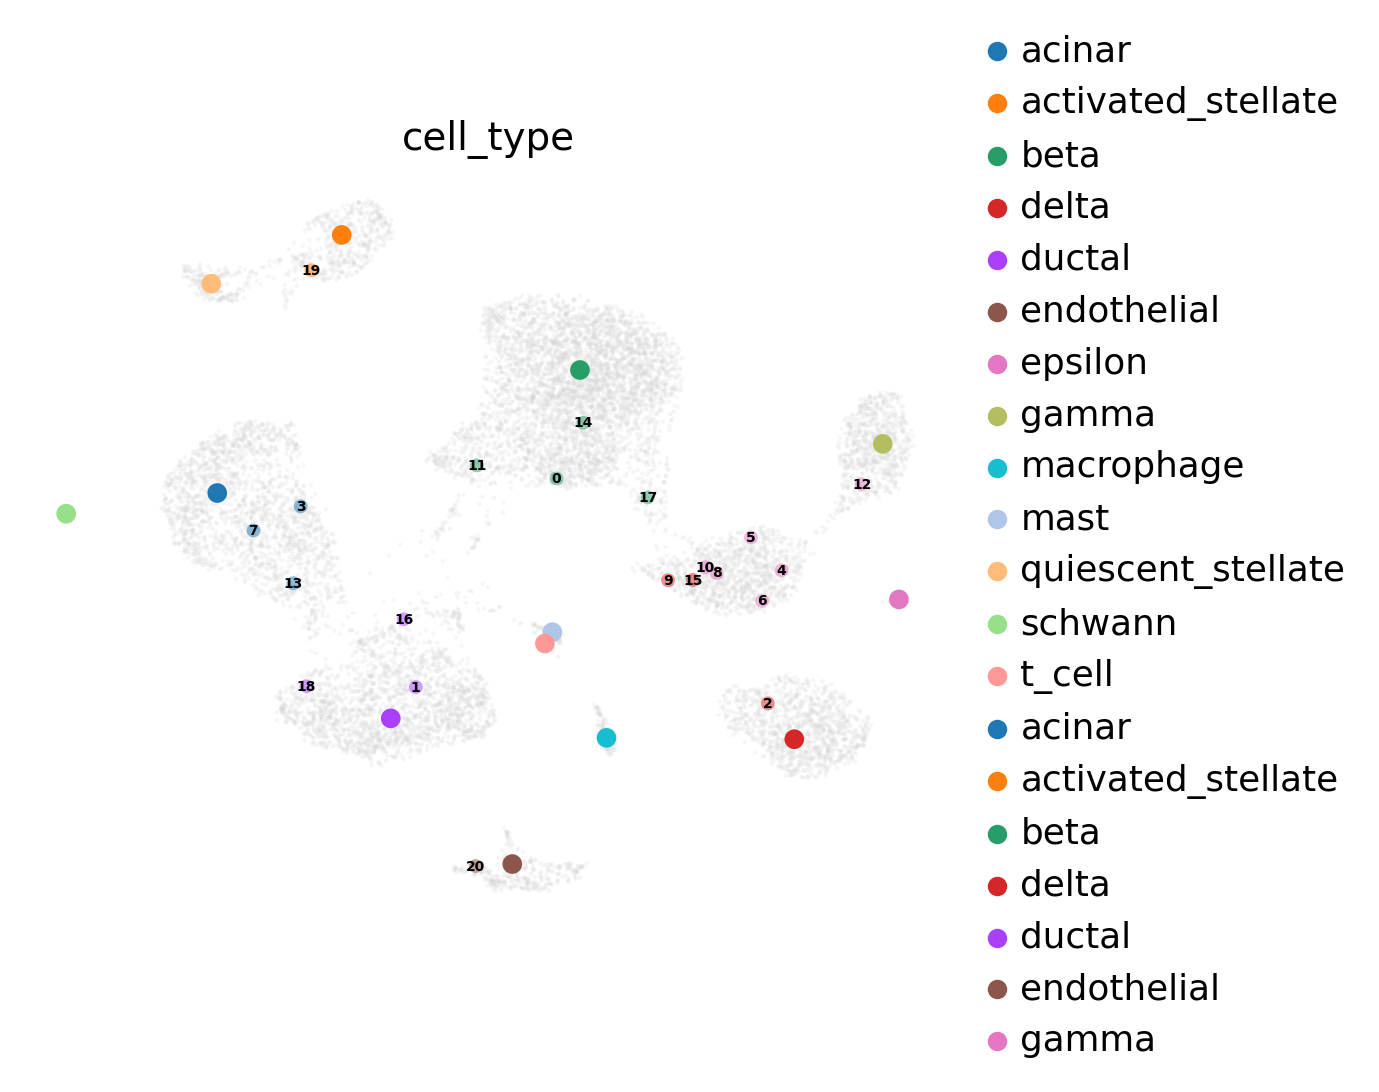

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
adata_labeled_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['2'])]
adata_unlabeled_prototypes = adata_latent_full[adata_latent_full.obs['query'].isin(['3'])]
adata_labeled_prototypes.obs['cell_type_pred'] = adata_labeled_prototypes.obs['cell_type_pred'].astype('category')
adata_unlabeled_prototypes.obs['cell_type_pred'] = adata_unlabeled_prototypes.obs['cell_type_pred'].astype('category')
adata_unlabeled_prototypes.obs['cell_type'] = adata_unlabeled_prototypes.obs['cell_type'].astype('category')

sc.pl.umap(
    adata_no_prototypes, 
    alpha=0.2, 
    show=False, 
    ax=ax
)
ax.legend([])
# plot labeled prototypes
sc.pl.umap(
    adata_labeled_prototypes,
    size=200,
    color=f'{cell_type_key}_pred',
    ax=ax,
    show=False,
    frameon=False,
)
# plot labeled prototypes
sc.pl.umap(
    adata_unlabeled_prototypes,
    size=100,
    color=[cell_type_key + '_pred'],
    palette=adata_labeled_prototypes.uns['cell_type_pred_colors'],
    ax=ax,
    show=False,
    frameon=False,
    alpha=0.5,
)
sc.pl.umap(
    adata_unlabeled_prototypes,
    size=0,
    color=cell_type_key,
    frameon=False,
    ax=ax,
    legend_loc='on data',
    legend_fontsize=5,
)
ax.set_title('Landmarks')
fig.tight_layout()

After inspecting the prototypes we can observe that unlabeled prototype 4, 5, 7, 8, 11 and 13 fall into the region of high uncertainty. With this knowledge, we can add a new labeled prototype.

In [26]:
scpoli_query.add_new_cell_type(
    "alpha", 
    cell_type_key, 
    [4, 5, 6, 8, 9, 10, 15]
)

In [27]:
results_dict = scpoli_query.classify(target_adata)

In [28]:
#get latent representation of reference data
scpoli_query.model.eval()
data_latent_source = scpoli_query.get_latent(
    source_adata,
    mean=True
)

adata_latent_source = sc.AnnData(data_latent_source)
adata_latent_source.obs = source_adata.obs.copy()

#get latent representation of query data
data_latent= scpoli_query.get_latent(
    target_adata,
    mean=True
)

adata_latent = sc.AnnData(data_latent)
adata_latent.obs = target_adata.obs.copy()

#get label annotations
adata_latent.obs['cell_type_pred'] = results_dict['cell_type']['preds'].tolist()
adata_latent.obs['cell_type_uncert'] = results_dict['cell_type']['uncert'].tolist()
adata_latent.obs['classifier_outcome'] = (
    adata_latent.obs['cell_type_pred'] == adata_latent.obs['cell_type']
)

#join adatas
adata_latent_full = adata_latent_source.concatenate(
    [adata_latent, labeled_prototypes, unlabeled_prototypes], 
    batch_key='query'
)
adata_latent_full.obs['cell_type_pred'][adata_latent_full.obs['query'].isin(['0'])] = np.nan
sc.pp.neighbors(adata_latent_full, n_neighbors=15)
sc.tl.umap(adata_latent_full)

<AxesSubplot: title={'center': 'cell_type_pred'}, xlabel='UMAP1', ylabel='UMAP2'>

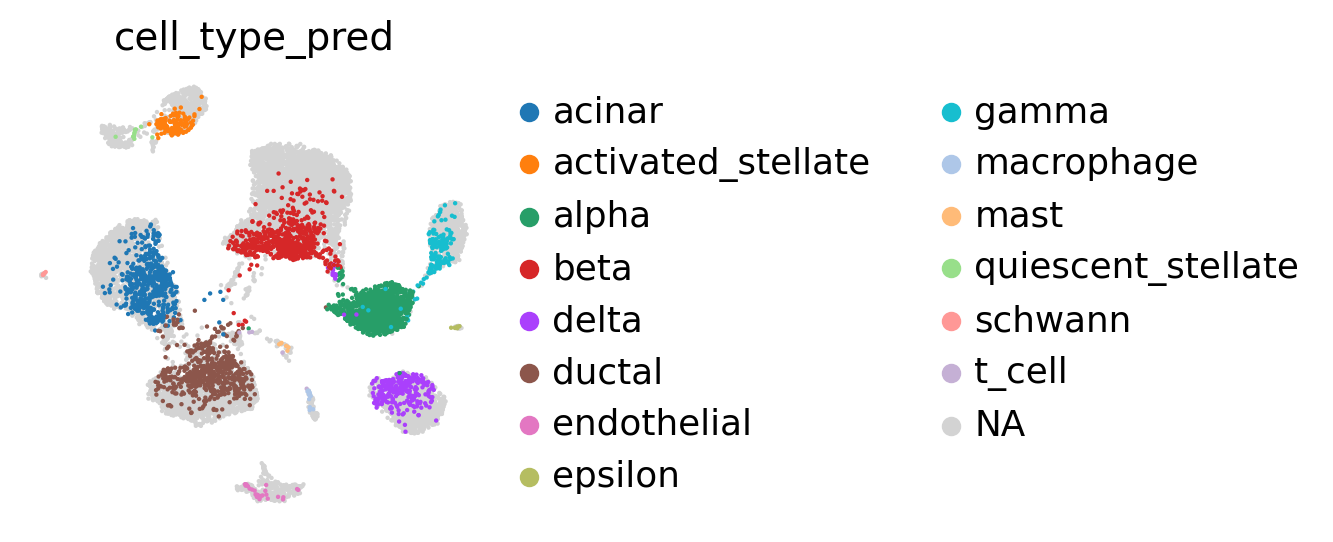

In [29]:
sc.pl.umap(
    adata_latent_full, 
    color='cell_type_pred',
    show=False, 
    frameon=False,
)

We can now see that the alpha cell cluster is correctly classified.

## Sample embeddings

We can extract the conditional embeddings learnt by scPoli and analyse them.

In [30]:
adata_emb = scpoli_query.get_conditional_embeddings()

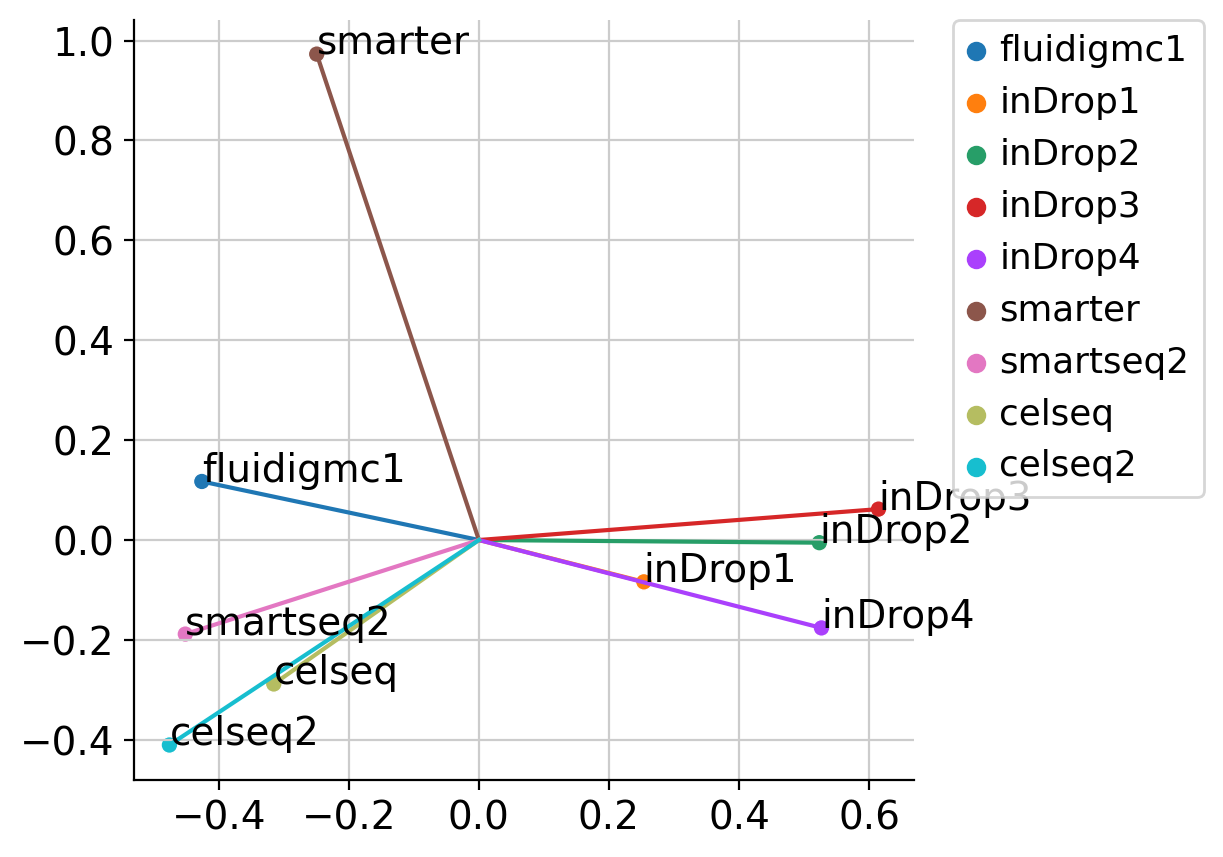

In [31]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA(n_components=2, kernel='linear')
emb_pca = pca.fit_transform(adata_emb.X)
conditions = scpoli_query.conditions_['study']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x=emb_pca[:, 0], y=emb_pca[:, 1], hue=conditions, ax=ax)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i, c in enumerate(conditions):
    ax.plot([0, emb_pca[i, 0]], [0, emb_pca[i, 1]])
    ax.text(emb_pca[i, 0], emb_pca[i, 1], c)
sns.despine()